In [ ]:
import pymysql
import pandas as pd

#подключение к базе данных
def get_connection():
    connection = pymysql.connect(host='database-3.chim8btj05zt.us-east-1.rds.amazonaws.com',
                                 user='admin',
                                 password='01035007',
                                 db='test',
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
    return connection


connection = get_connection()

try:
    with connection.cursor() as cursor:
        print("выгрузка датасета")
        s = "SELECT count(*) AS count FROM sort_v2 WHERE ttype = -1"
        cursor.execute(s)
        c1 = cursor.fetchone()['count']
        s = "SELECT count(*) AS count FROM sort_v2 WHERE ttype = 1"
        cursor.execute(s)
        c2 = cursor.fetchone()['count']
        min_c = min(c1, c2)

        s = "SELECT ttext_stem, ttype FROM sort_v2 WHERE ttype = -1 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_n = pd.DataFrame(result)
        print(data_n.head(5))
        s = "SELECT ttext_stem, ttype FROM sort_v2 WHERE ttype = 1 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_p = pd.DataFrame(result)
        print(data_p.head(5))

        raw_data = pd.concat([data_p, data_n], ignore_index = True)
        raw_data = raw_data.sample(frac=1).reset_index(drop=True)  
        print(f"Обучающий набор: {raw_data.shape}")

        print("выгрузка тестовых данных")
        s = "SELECT count(*) AS count FROM linis_texts WHERE ttype = -1 OR ttype = -2"
        cursor.execute(s)
        c1 = cursor.fetchone()['count']
        s = "SELECT count(*) AS count FROM linis_texts WHERE ttype = 1 OR ttype = 2"
        cursor.execute(s)
        c2 = cursor.fetchone()['count']
        min_c = min(c1, c2)

        s = "SELECT ttext_stem, ttype FROM linis_texts WHERE ttype = -1 OR ttype = -2 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_n = pd.DataFrame(result)
        print(data_n.head(5))

        s = "SELECT ttext_stem, ttype FROM linis_texts WHERE ttype = 1 OR ttype = 2 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_p = pd.DataFrame(result)
        print(data_p.head(5))

        test_data = pd.concat([data_p, data_n], ignore_index = True)
        #test_data = test_data.loc[test_data['ttype'] != 0]

        data_p = None
        data_n = None
        result = None

        test_data = test_data.sample(frac=1).reset_index(drop=True)  
        print(f"Тестовые данные: {test_data.shape}")
    
finally:
    connection.close()

выгрузка датасета
                                          ttext_stem  ttype
0  работа|полный|пиддес|равнодушие|скука|каждый|з...     -1
1  коллега|сидеть|рубиться|urban|terror|долбать|в...     -1
2                    user|говорят|обещаной|год|ждать     -1
3  желать|хороший|полёт|удачный|посадка|очень|сил...     -1
4  обновить|леший|surf|работать|простоплеер|груст...     -1
                                          ttext_stem  ttype
0  user|школотый|поверь|самый|смех|общество|профи...      1
1  весь|таки|немного|похожий|мальчик|весь|равно|х...      1
2                         rt|user|идиотка|испугаться      1
3  rt|user|угол|сидеть|погибать|голод|ещё|порция|...      1
4  user|значит|страшилка|смех|блин|посмотреть|вес...      1
Обучающий набор: (223846, 2)
выгрузка тестовых данных
                                          ttext_stem  ttype
0  htm|обсуждать|сайт|весь|рядовой|гражданин|жить...     -2
1  приватизация|это|первородный|грех|антикоммунис...     -2
2  обычный|дело|улыбка|шутка

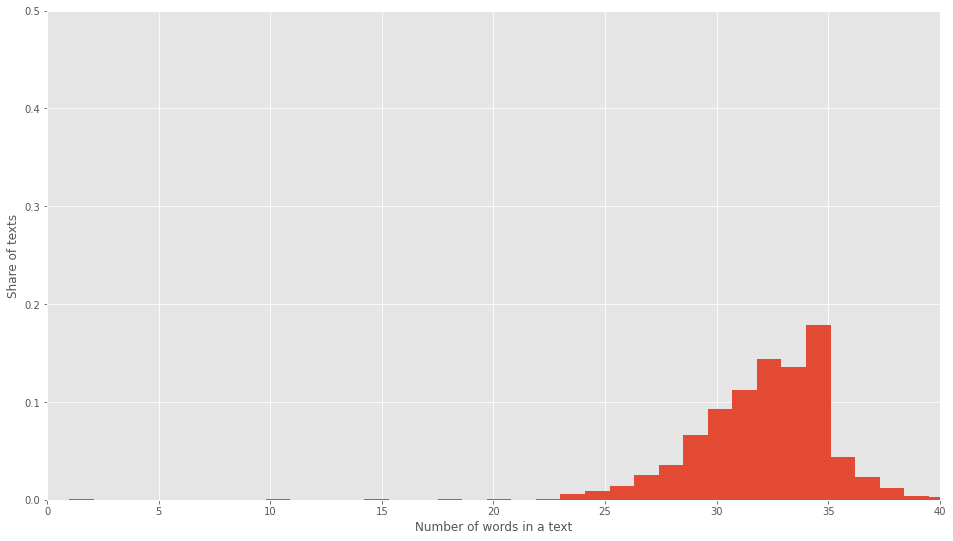

In [ ]:
#гистограмма наиболее часто встречающегося количества слов
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(16, 9)) 
# facecolor='g'
len_of_sent = test_data['ttext_stem'].apply(lambda x: len(x.split('|')))
n, bins, patches = plt.hist(len_of_sent, 50, density=True)
plt.xlabel('Number of words in a text')
plt.ylabel('Share of texts')
plt.axis([0, 40, 0, 0.5])
plt.grid(True)
plt.show()

#больше всего предложений длиной 8 слов. выбираем количество анализируемых слов = 25

In [ ]:
#загрузка модели Doc2Vec

import numpy as np
from gensim.models import Doc2Vec
from google.colab import drive

drive.mount('/gdrive')
model = Doc2Vec.load("/gdrive/My Drive/Colab Notebooks/doc2vec_dbow/model_dbow_iter_10.doc2vec")
model.delete_temporary_training_data()

DIM = model.vector_size

print("подготовка обучающего набора")
data = [row.split('|') for row in raw_data['ttext_stem']]
X_train = [model.infer_vector(d) for d in data]

print(f"Количество слов в предложении: {len(X_train[0])}")
print(X_train)

Y_train = [1 if d == 1 else 0 for d in raw_data['ttype']]
print(Y_train)

print("подготовка тестового набора")
data_t = [row.split('|') for row in test_data['ttext_stem']]
X_test = [model.infer_vector(d) for d in data_t]

print(f"Количество слов в предложении: {len(X_test[0])}")
print(X_test)

Y_test = [1 if d == 1 or d == 2 else 0 for d in test_data['ttype']]
print(Y_test)


#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


подготовка обучающего набора
Количество слов в предложении: 500


In [ ]:
from keras import backend as K 

# Метрики 
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
'''
#загрузка модели Doc2Vec
from gensim.models import Doc2Vec
from google.colab import drive

drive.mount('/gdrive')
model = Word2Vec.load("/gdrive/My Drive/Colab Notebooks/doc2vec_dm/mode_dm_iter_23.doc2vec")

DIM_D2V = model.vector_size

# матрица входных значений для всех предложений из размеченной БД
e_matrix = np.zeros((len(data), DIM_D2V))
for i, d in enumerate(data):
    e_matrix[i] = model.infer_vector(d)


In [ ]:
#обучение нейронной сети
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

model = Sequential() 
model.add(Dense(100, input_dim=DIM, activation="relu")) #, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(10, input_dim=50, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='mean_squared_error', optimizer='adam', , metrics=['accuracy', precision, recall, f1])
model.summary()


In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/cnn-doc2vec_dbow-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

In [ ]:
'''
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32') 
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH, weights=[e_matrix], trainable=False)(tweet_input) #Слой Emdedding

branches = []

x = Dropout(0.2)(tweet_encoder)
for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary()


In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings_1-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
#model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings-08-0.82.hdf5')

In [ ]:
from sklearn.metrics import classification_report
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))

In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings_2-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
#model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings-08-0.82.hdf5')

In [ ]:
from sklearn.metrics import classification_report
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))

In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings-08-0.82.hdf5')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/cnn-frozen2-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
#model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings-_____.hdf5')

In [ ]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))


In [ ]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', precision, recall, f1])
model.summary()# Модель с размороженным emdedding

In [ ]:
checkpoint = ModelCheckpoint("cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
model.load_weights('cnn-trainable-____.hdf5')

In [ ]:
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))